In [16]:
import numpy as np
import time
import os
import cv2
import sys

# Now cluster the data

%pylab inline


home_dir = os.path.abspath('../../../')
sys.path.append(home_dir)

import sys; sys.argv=['']; del sys
from loaders.loader_uadetrac import LoaderUADetrac
import torch
import torch.nn as nn
import gc
gc.collect()
torch.cuda.set_device(0)


Populating the interactive namespace from numpy and matplotlib


/nethome/jbang36/anaconda3/envs/eva_37/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [17]:
load = LoaderUADetrac(image_width = 224, image_height = 224)
X = load.load_cached_images()

In [19]:
X_norm = np.copy(X).astype(np.float)
X_norm /= 255

### Pytorch Version

In [11]:
# Writing our model
class WNet(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.K = 5
        self.output_channels = 3
        self.input_channels = 3
        
        self.create_enc()
        self.create_dec()

        
    def forward(self,x):
        #enc names: u_enc1,...7
        #dec names: u_dec1,...7
        x1 = self.u_enc1(x)
        x2 = self.u_enc2(x1)
        x3 = self.u_enc3(x2)
        x4 = self.u_enc4(x3)
        x5 = self.u_enc5(x4)
        x4_5 = torch.cat([x4,x5], dim = 1)
        x6 = self.u_enc6(x4_5)
        x3_6 = torch.cat([x3,x6], dim = 1)
        x7 = self.u_enc7(x3_6)
        x2_7 = torch.cat([x2,x7], dim = 1)
        x8 = self.u_enc8(x2_7)
        x1_8 = torch.cat([x1,x8], dim = 1)
        segmented = self.u_enc9(x1_8)
        
        ##output of segmented should have self.k channels
        x10 = self.u_dec10(segmented)
        x11 = self.u_dec11(x10)
        x12 = self.u_dec12(x11)
        x13 = self.u_dec13(x12)
        x14 = self.u_dec14(x13)
        x13_14 = torch.cat([x13, x14], dim = 1)
        x15 = self.u_dec15(x13_14)
        x12_15 = torch.cat([x12, x15], dim = 1)
        x16 = self.u_dec16(x12_15)
        x11_16 = torch.cat([x11,x16], dim = 1)
        x17 = self.u_dec17(x11_16)
        x10_17 = torch.cat([x10, x17], dim = 1)
        reconstructed = self.u_dec18(x10_17)
        
        return [segmented,reconstructed]
    
    
    def create_enc(self):
        self.u_enc1 = nn.Sequential()
        self.u_enc1.add_module('Conv1_1', nn.Conv2d(self.input_channels, 64, kernel_size=3, padding = (1,1)))
        self.u_enc1.add_module('Relu1_2', nn.LeakyReLU(True))
        self.u_enc1.add_module('Conv1_3', nn.Conv2d(64,64,kernel_size=3, padding = (1,1)))
        self.u_enc1.add_module('Relu1_4', nn.LeakyReLU(True))
        
        self.u_enc2 = nn.Sequential()
        self.u_enc2.add_module('Max2_1', nn.MaxPool2d(2, stride = 2))
        self.u_enc2.add_module('Conv2_2', nn.Conv2d(64, 128, kernel_size=3, padding = (1,1)))
        self.u_enc2.add_module('Relu2_3', nn.LeakyReLU(True))
        self.u_enc2.add_module('Conv2_4', nn.Conv2d(128, 128, kernel_size=3, padding = (1,1)))
        self.u_enc2.add_module('Relu2_5', nn.LeakyReLU(True))
        
        self.u_enc3 = nn.Sequential()
        self.u_enc3.add_module('Max3_1', nn.MaxPool2d(2, stride = 2))
        self.u_enc3.add_module('Conv3_2', nn.Conv2d(128, 256, kernel_size=3, padding = (1,1)))
        self.u_enc3.add_module('Relu3_3', nn.LeakyReLU(True))
        self.u_enc3.add_module('Conv3_4', nn.Conv2d(256, 256, kernel_size=3, padding = (1,1)))
        self.u_enc3.add_module('Relu3_5', nn.LeakyReLU(True))
        
        self.u_enc4 = nn.Sequential()
        self.u_enc4.add_module('Max4_1', nn.MaxPool2d(2, stride = 2))
        self.u_enc4.add_module('Conv4_2', nn.Conv2d(256, 512, kernel_size=3, padding = (1,1)))
        self.u_enc4.add_module('Relu4_3', nn.LeakyReLU(True))
        self.u_enc4.add_module('Conv4_4', nn.Conv2d(512, 512, kernel_size=3, padding = (1,1)))
        self.u_enc4.add_module('Relu4_5', nn.LeakyReLU(True))
        
        self.u_enc5 = nn.Sequential()
        self.u_enc5.add_module('Max5_1', nn.MaxPool2d(2, stride = 2))
        self.u_enc5.add_module('Conv5_2', nn.Conv2d(512, 1024, kernel_size=3, padding = (1,1)))
        self.u_enc5.add_module('Relu5_3', nn.LeakyReLU(True))
        self.u_enc5.add_module('Conv5_4', nn.Conv2d(1024, 1024, kernel_size=3, padding = (1,1)))
        self.u_enc5.add_module('Relu5_5', nn.LeakyReLU(True))
        self.u_enc5.add_module('CT5_6', nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2))
        
        
        self.u_enc6 = nn.Sequential()
        self.u_enc6.add_module('Conv6_1', nn.Conv2d(1024, 512, kernel_size=3, padding = (1,1)))
        self.u_enc6.add_module('Relu6_2', nn.LeakyReLU(True))
        self.u_enc6.add_module('Conv6_3', nn.Conv2d(512, 512, kernel_size=3, padding = (1,1)))
        self.u_enc6.add_module('Relu6_4', nn.LeakyReLU(True))
        self.u_enc6.add_module('CT6_5', nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2))
        
        self.u_enc7 = nn.Sequential()
        self.u_enc7.add_module('Conv7_1', nn.Conv2d(512, 256, kernel_size=3, padding = (1,1)))
        self.u_enc7.add_module('Relu7_2', nn.LeakyReLU(True))
        self.u_enc7.add_module('Conv7_3', nn.Conv2d(256, 256, kernel_size=3, padding = (1,1)))
        self.u_enc7.add_module('Relu7_4', nn.LeakyReLU(True))
        self.u_enc7.add_module('CT7_5', nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2))
        
        self.u_enc8 = nn.Sequential()
        self.u_enc8.add_module('Conv8_1', nn.Conv2d(256, 128, kernel_size=3, padding = (1,1)))
        self.u_enc8.add_module('Relu8_2', nn.LeakyReLU(True))
        self.u_enc8.add_module('Conv8_3', nn.Conv2d(128, 128, kernel_size=3, padding = (1,1)))
        self.u_enc8.add_module('Relu8_4', nn.LeakyReLU(True))
        self.u_enc8.add_module("Conv8_5", nn.Conv2d(128, 64, kernel_size = 1))
        self.u_enc8.add_module('Soft8_6', nn.Softmax())

        self.u_enc9 = nn.Sequential()
        self.u_enc9.add_module('Conv9_1', nn.Conv2d(128, 64, kernel_size=3, padding = (1,1)))
        self.u_enc9.add_module('Relu9_2', nn.LeakyReLU(True))
        self.u_enc9.add_module('Conv9_3', nn.Conv2d(64, 64, kernel_size=3, padding = (1,1)))
        self.u_enc9.add_module('Relu9_4', nn.LeakyReLU(True))
        self.u_enc9.add_module("Conv9_5", nn.Conv2d(64, self.K, kernel_size = 1))
        self.u_enc9.add_module('Soft9_6', nn.Softmax())

    
    def create_dec(self):
        self.u_dec10 = nn.Sequential()
        self.u_dec10.add_module('Conv8_1', nn.Conv2d(self.K, 64, kernel_size=3, padding = (1,1)))
        self.u_dec10.add_module('Relu8_2', nn.LeakyReLU(True))
        self.u_dec10.add_module('Conv8_3', nn.Conv2d(64,64,kernel_size=3, padding = (1,1)))
        self.u_dec10.add_module('Relu8_4', nn.LeakyReLU(True))
        
        self.u_dec11 = nn.Sequential()
        self.u_dec11.add_module('Max9_1', nn.MaxPool2d(2, stride = 2))
        self.u_dec11.add_module('Conv9_2', nn.Conv2d(64, 128, kernel_size=3, padding = (1,1)))
        self.u_dec11.add_module('Relu9_3', nn.LeakyReLU(True))
        self.u_dec11.add_module('Conv9_4', nn.Conv2d(128, 128, kernel_size=3, padding = (1,1)))
        self.u_dec11.add_module('Relu9_5', nn.LeakyReLU(True))
        
        self.u_dec12 = nn.Sequential()
        self.u_dec12.add_module('Maxa_1', nn.MaxPool2d(2, stride = 2))
        self.u_dec12.add_module('Conva_2', nn.Conv2d(128, 256, kernel_size=3, padding = (1,1)))
        self.u_dec12.add_module('Relua_3', nn.LeakyReLU(True))
        self.u_dec12.add_module('Conva_4', nn.Conv2d(256, 256, kernel_size=3, padding = (1,1)))
        self.u_dec12.add_module('Relua_5', nn.LeakyReLU(True))
        
        self.u_dec13 = nn.Sequential()
        self.u_dec13.add_module('Maxb_1', nn.MaxPool2d(2, stride = 2))
        self.u_dec13.add_module('Convb_2', nn.Conv2d(256, 512, kernel_size=3, padding = (1,1)))
        self.u_dec13.add_module('Relub_3', nn.LeakyReLU(True))
        self.u_dec13.add_module('Convb_4', nn.Conv2d(512, 512, kernel_size=3, padding = (1,1)))
        self.u_dec13.add_module('Relub_5', nn.LeakyReLU(True))
        
        self.u_dec14 = nn.Sequential()
        self.u_dec14.add_module('Maxc_1', nn.MaxPool2d(2, stride = 2))
        self.u_dec14.add_module('Convc_1', nn.Conv2d(512, 1024, kernel_size=3, padding = (1,1)))
        self.u_dec14.add_module('Reluc_2', nn.LeakyReLU(True))
        self.u_dec14.add_module('Convc_3', nn.Conv2d(1024, 1024, kernel_size=3, padding = (1,1)))
        self.u_dec14.add_module('Reluc_4', nn.LeakyReLU(True))
        self.u_dec14.add_module('CTc_5', nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2))
          
        self.u_dec15 = nn.Sequential()
        self.u_dec15.add_module('Convd_1', nn.Conv2d(1024, 512, kernel_size=3, padding = (1,1)))
        self.u_dec15.add_module('Relud_2', nn.LeakyReLU(True))
        self.u_dec15.add_module('Convd_3', nn.Conv2d(512, 512, kernel_size=3, padding = (1,1)))
        self.u_dec15.add_module('Relud_4', nn.LeakyReLU(True))
        self.u_dec15.add_module('CTd_5', nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2))
        
        self.u_dec16 = nn.Sequential()
        self.u_dec16.add_module('Conve_1', nn.Conv2d(512, 256, kernel_size=3, padding = (1,1)))
        self.u_dec16.add_module('Relue_2', nn.LeakyReLU(True))
        self.u_dec16.add_module('Conve_3', nn.Conv2d(256, 256, kernel_size=3, padding = (1,1)))
        self.u_dec16.add_module('Relue_4', nn.LeakyReLU(True))
        self.u_dec16.add_module('CTe_5', nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2))
        
        self.u_dec17 = nn.Sequential()
        self.u_dec17.add_module('Convf_1', nn.Conv2d(256, 128, kernel_size=3, padding = (1,1)))
        self.u_dec17.add_module('Reluf_2', nn.LeakyReLU(True))
        self.u_dec17.add_module('Convf_3', nn.Conv2d(128, 128, kernel_size=3, padding = (1,1)))
        self.u_dec17.add_module('Reluf_4', nn.LeakyReLU(True))
        self.u_dec17.add_module('CTf_5', nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2))
        
        self.u_dec18 = nn.Sequential()
        self.u_dec18.add_module('Convg_1', nn.Conv2d(128, 64, kernel_size=3, padding = (1,1)))
        self.u_dec18.add_module('Relug_2', nn.LeakyReLU(True))
        self.u_dec18.add_module('Convg_3', nn.Conv2d(64, 64, kernel_size=3, padding = (1,1)))
        self.u_dec18.add_module('Relug_4', nn.LeakyReLU(True))
        self.u_dec18.add_module("Convg_5", nn.Conv2d(64, self.output_channels, kernel_size = 1))
        
        
        
        
        

In [12]:
#defining some params
#w-net metions, learning rate is divided by 10 after 1000 iterations, 
# training stopped after 50,000 iterations
num_epochs = 100 
batch_size = 16

In [13]:
# Create custom loss function

def calculate_denom(segmented_imgs, weight_matrix):
    # segmented_imgs: torch.Size(N,K,H,W)
    # weight_matrix: torch.Size(N,H,W,HxW)
    # steps:
    # 1. create the expanded matrix
    # 2. multiply with weight_matrix
    # 3. tensor sum wrt depth
    # 4. tensor sum wrt h,w
    # 5. should be a number
    #seg = segmented_imgs
    #seg = torch.tensor(segmented_imgs.data.clone(), requires_grad = True)
    seg = segmented_imgs.clone()
    N,K,H,W = seg.size()
    seg.unsqueeze_(-1)
    seg = seg.expand(-1, -1, -1,-1,H*W)
    assert(seg.size() == torch.Size([N,K,H,W,H*W]))
    #weight_matrix.unsqueeze_(1)
    #weight_matrix = weight_matrix.expand(-1,K,-1,-1,-1) #N,K,H,W,H*W
    assert(weight_matrix.size() == torch.Size([N,K,H,W,H*W]))
    seg = torch.mul(seg, weight_matrix)
    return seg.sum((2,3,4))

def calculate_num(segmented_imgs, weight_matrix):
    # segmented_imgs: torch.Size(N,K,H,W)
    # weight_matrix will be of size (N,H,W,HxW)
    
    N,K,H,W = segmented_imgs.size()
    #seg1 = torch.tensor(segmented_imgs.data.clone(), requires_grad = True)
    #seg2 = torch.tensor(seg1.clone(), requires_grad = True)
    seg1 = segmented_imgs.clone()
    seg2 = segmented_imgs.clone()
    
    seg1.unsqueeze_(-1) # N,K,H,W,1
    seg1 = seg1.expand(-1, -1, -1, -1, H*W)
    seg2.unsqueeze_(-1) # N,K,H,W,1
    seg2 = seg2.reshape(N,K, 1, 1, -1) # N,K,1,1,H*W
    seg2 = seg2.expand(-1,-1, H, W, -1) # N,K,H,W,H*W
    assert(seg1.size() == seg2.size())
    seg1 = torch.mul(seg1, seg2) # N,K,H,W,H*W
    
    seg1 = torch.mul(seg1, weight_matrix) #N,K,H,W,H*W
    return seg1.sum((2,3,4))

def calculate_dist_matrix(N, H, W):
    
    sigma_x_squared = 16
    #x_matrix1 = torch.arange(end = H, dtype=torch.float, requires_grad=True).cuda()
    x_matrix1 = torch.arange(end = H, dtype=torch.float).cuda()
    
    x_matrix1.unsqueeze_(-1)
    x_matrix1 = x_matrix1.expand(-1, W)
    x_matrix1.unsqueeze_(-1)
    x_matrix1 = x_matrix1.expand(-1,-1,H*W)
    
    #x_matrix2 = torch.arange(end = H, dtype = torch.float, requires_grad = True).cuda()
    x_matrix2 = torch.arange(end = H, dtype = torch.float).cuda()
    x_matrix2.unsqueeze_(-1)
    x_matrix2 = x_matrix2.expand(-1,W)
    x_matrix2.unsqueeze_(-1)
    x_matrix2 = x_matrix2.reshape(1,1,-1)
    x_matrix2 = x_matrix2.expand(H,W,-1)
    
    x_matrix1 = x_matrix1 - x_matrix2
    x_matrix1 = torch.pow(x_matrix1, 2)
    
    #y_matrix1 = torch.arange(end = W, dtype=torch.float, requires_grad=True ).cuda()
    y_matrix1 = torch.arange(end = W, dtype=torch.float).cuda()
    y_matrix1.unsqueeze_(-1)
    y_matrix1 = y_matrix1.expand(-1, H)
    y_matrix1 = y_matrix1.permute(1,0)
    y_matrix1.unsqueeze_(-1)
    y_matrix1 = y_matrix1.expand(-1,-1,H*W)
    
    #y_matrix2 = torch.arange(end = W, dtype = torch.float, requires_grad = True).cuda()
    y_matrix2 = torch.arange(end = W, dtype = torch.float).cuda()
    y_matrix2 = y_matrix2.repeat(H)
    y_matrix2.unsqueeze_(-1)
    y_matrix2.unsqueeze_(-1)
    y_matrix2 = y_matrix2.permute(1,2,0)
    y_matrix2 = y_matrix2.expand(H,W,-1)
    
    y_matrix1 = y_matrix1 - y_matrix2
    y_matrix1 = torch.pow(y_matrix1,2)
    
    dist_diff = torch.exp( -torch.div(x_matrix1+y_matrix1, sigma_x_squared) )
    assert(dist_diff.size() == torch.Size([H,W,H*W]))
    dist_diff.unsqueeze_(0)
    dist_diff = dist_diff.expand(N,-1, -1, -1) #N,H,W,H*W

    return dist_diff

def create_weight_matrix(N, H, W, K, dist_diff, original_img):
    # given the corresponding height and width, will create a weight matrix of size H,W,HxW according to the formula given in
    # w-net paper.
    # original_img size: torch.Size(N,C,H,W)
    # dist_diff size: torch.Size(N,H,W,H*W)
    # we will assume matrix of size H, W is given, it is initialized to zeros
    
    sigma_i_squared = 100
    r = 5
     
    #matrix1 = original_img
    #matrix1 = torch.tensor(original_img.clone(), requires_grad = True)
    matrix1 = original_img.clone()
    matrix1.unsqueeze_(-1)
    matrix1 = matrix1.expand(-1,-1,-1,-1,H*W)
    assert(matrix1.size() == torch.Size([N,C,H,W,H*W]))
    
    #matrix2 = torch.tensor(original_img.clone(), requires_grad = True)
    #matrix2 = original_img
    matrix2 = original_img.clone()
    matrix2.unsqueeze_(-1)
    matrix2 = matrix2.reshape(N,C,1,1,-1) #N,C,1,1,H*W
    matrix2 = matrix2.expand(-1,-1,H,W,-1) #N,C,H,W,H*W
    assert(matrix2.size() == torch.Size([N,C,H,W,H*W]))
    matrix1 = matrix1 - matrix2
    matrix1 = torch.pow(matrix1,2) #N,C,H,W,H*W
    
    matrix1 = torch.exp( -torch.div( matrix1.sum(1), sigma_i_squared) ) #N,H,W,H*W
    weight = torch.pow(matrix1, 2) #N,H,W,H*W
    assert(weight.size() == torch.Size([N,H,W,H*W]))
    weight.unsqueeze_(1)
    weight = weight.expand(-1,K,-1,-1,-1) #N,K,H,W,H*W
    
    return weight
    
    
#TODO: Need to convert this to 4d matrix because we expect to pass in multiple samples
def softcut_loss(segmented_imgs, original_imgs, dist_diff_matrix):
    N,K,H,W = segmented_imgs.size()
    loss = 0
    wt = 0
    nt = 0
    dt = 0
    
    weight_matrix = create_weight_matrix(N, H, W, K, dist_diff_matrix, original_imgs)
    
    num = calculate_num(segmented_imgs, weight_matrix)
    denom = calculate_denom(segmented_imgs, weight_matrix)
    
    # returned num, denom is torch.Size([N,K])
    
    total_sum = torch.sum(torch.div(num, denom))
    return N*K - total_sum
    
    
    ### Before batch processing
    """
    for i in range(N):
        segmented_img = segmented_imgs[i,:,:,:]
        original_img = original_imgs[i,:,:,:]
        weight_matrix = create_weight_matrix(N,H,W, dist_diff_matrix, original_img)
        
        frac_sum = 0
        
        #used for profiling
        num_time = 0
        denom_time = 0
        for j in range(K):
            num = calculate_num(segmented_img[j,:,:], weight_matrix)
            
            denom = calculate_denom(segmented_img[j,:,:], weight_matrix)
            frac_sum += num / denom
            
    return K - frac_sum
    """
    ### End
        


In [14]:
model = Autoencoder().cuda()
distance = nn.MSELoss()



In [15]:
def print_grad(mess):
    print(mess)
    print(model.u_enc1.Conv1_1.weight[0,:,:,:])
    grad = model.u_enc1.Conv1_1.weight.grad
    if grad is not None:
        print(grad[0,:,:,:])
    else:
        print("***Printing grad***")
        print(grad)
    print("----------------------------")
    return


In [16]:
# Loss Function Revision


n_samples, H, W, C = X_train_norm.shape

train_data = torch.from_numpy(X_train_norm).float()
train_data = train_data.permute(0,3,1,2)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4, drop_last=True)

#dist_diff_matrix = calculate_dist_matrix(batch_size, H,W)


In [ ]:
## Paper training stats
# learning_rate = 0.003
# dropout rate is 0.65
# batch size is 10
# learning rate dropped by 10 every 1000 iteration
# training stopped at 50000 iterations (assuming this is epoch)
learning_rate = 0.0001 # our loop starts by dividing 10
batch_size = 1024
total_epochs = 200



optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)
for epoch in range(total_epochs):
 #   if epoch % 1000 == 0:
 #       optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)
    
    st = time.perf_counter()
    for i, images in enumerate(train_loader):    # Ignore image labels
        images_cuda = images.cuda()
        _, recon = model(images_cuda)  
        #print_grad("Before zero_grad") ##

        optimizer.zero_grad()
        #print_grad("After zero_grad") ##
        
        loss2 = distance(recon, images_cuda)
        loss2.backward()
        #print_grad("After 2nd loss backward")
        optimizer.step()
        #print_grad("After 2nd grad application")

    print('epoch [{}/{}], loss2:{:.4f}, time elapsed:{:.4f} (sec)'.format(epoch+1, total_epochs, loss2.data, time.perf_counter() - st))



In [18]:
X_test_torch = torch.from_numpy(X_test_norm[0:10]).float()
test_data = X_test_torch.permute(0,3,1,2)
test_cuda = test_data.cuda()
seged, recon = model(test_cuda)

In [ ]:
recon_p = recon.permute(0,2,3,1)
print(recon_p.size())

recon_imgs = recon_p.detach().cpu().numpy()
recon_imgs *= 255
recon_imgs = recon_imgs.astype(np.uint8)
#print(recon_imgs[4,:,:,0])
for i in range(10):
    plt.imshow(recon_imgs[i])
    plt.show()

In [ ]:
# Try to visualize segmented image

print(torch.max(seged))
print(torch.min(seged))


K = 5
arged = torch.argmax(seged, dim = 1) #channels is 1
arged = arged * 255 / (K - 1)
arged_imgs = arged.detach().cpu().numpy()

print(recon_p.size())

arged_imgs = arged_imgs.astype(np.uint8)
#print(recon_imgs[4,:,:,0])
for i in range(10):
    plt.imshow(arged_imgs[i])
    plt.show()

In [22]:
num_epochs = 100
batch_size = 16


n_samples, H, W, C = X_train_norm.shape

train_data = torch.from_numpy(X_train_norm).float()
train_data = train_data.permute(0,3,1,2)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4, drop_last=True)

dist_diff_matrix = calculate_dist_matrix(batch_size, H,W)


In [26]:



num_epochs = 20
for epoch in range(num_epochs):
    st = time.perf_counter()
    for i, images in enumerate(train_loader):    # Ignore image labels
        images_cuda = images.cuda()
        seg, recon = model(images_cuda)  
        #print_grad("Before zero_grad") ##

        optimizer.zero_grad()
        #print_grad("After zero_grad") ##
        loss1 = softcut_loss(seg, images_cuda, dist_diff_matrix)
        loss1.backward(retain_graph = True)
        #print_grad("After back prop") ##
        optimizer.step()
        #print_grad("After application")
        optimizer.zero_grad()
        #print_grad("After 2nd zero grad")
        
        #loss2 = distance(recon, images_cuda)
        #loss2.backward()
        #print_grad("After 2nd loss backward")
        #optimizer.step()
        #print_grad("After 2nd grad application")
        
    #print('epoch [{}/{}], loss1:{:.4f}, loss2:{:.4f}, time elapsed:{:.4f} (sec)'.format(epoch+1, num_epochs, loss1.data, loss2.data, time.perf_counter() - st))
    print('epoch [{}/{}], loss1:{:.4f}, time elapsed:{:.4f} (sec)'.format(epoch+1, num_epochs, loss1.data, time.perf_counter() - st))


epoch [1/20], loss1:63.9504, time elapsed:166.0849 (sec)
epoch [2/20], loss1:63.9485, time elapsed:166.1947 (sec)
epoch [3/20], loss1:63.9471, time elapsed:166.0802 (sec)
epoch [4/20], loss1:63.9490, time elapsed:165.9151 (sec)
epoch [5/20], loss1:63.9523, time elapsed:165.9234 (sec)
epoch [6/20], loss1:63.9518, time elapsed:166.0576 (sec)
epoch [7/20], loss1:63.9472, time elapsed:165.9695 (sec)
epoch [8/20], loss1:63.9499, time elapsed:166.1045 (sec)
epoch [9/20], loss1:63.9506, time elapsed:165.9910 (sec)
epoch [10/20], loss1:63.9531, time elapsed:165.9275 (sec)
epoch [11/20], loss1:63.9457, time elapsed:166.0412 (sec)
epoch [12/20], loss1:63.9496, time elapsed:166.1836 (sec)
epoch [13/20], loss1:63.9480, time elapsed:165.9803 (sec)
epoch [14/20], loss1:63.9511, time elapsed:166.0289 (sec)
epoch [15/20], loss1:63.9478, time elapsed:166.1762 (sec)
epoch [16/20], loss1:63.9422, time elapsed:166.0118 (sec)
epoch [17/20], loss1:63.9493, time elapsed:165.8696 (sec)
epoch [18/20], loss1:63

In [ ]:
# Try to visualize segmented image

print(torch.max(seged))
print(torch.min(seged))


K = 5
arged = torch.argmax(seged, dim = 1) #channels is 1
arged = arged * 255 / (K - 1)
arged_imgs = arged.detach().cpu().numpy()

print(recon_p.size())

arged_imgs = arged_imgs.astype(np.uint8)
#print(recon_imgs[4,:,:,0])
for i in range(10):
    plt.imshow(arged_imgs[i])
    plt.show()

In [38]:
# use test data to confirm the reconstruction

test_data = torch.from_numpy(X_test_norm).float()
test_data = test_data.permute(0,3,1,2)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size, num_workers=4, drop_last=True)

for i, images in enumerate(test_loader):    # Ignore image labels
    images_cuda = images.cuda()
    seg, recon = model(images_cuda)
    break
    
recon_perm = recon.cpu().permute(0,2,3,1) #channels last




In [39]:
print(recon_perm[0,:,:,0])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<SelectBackward>)


In [ ]:
print(recon_perm.size())
recon_ = recon_perm.detach().numpy()
print(recon_.shape)

for i in range(recon_.shape[0]):
    example = recon_[i]
    width, height, channels = example.shape
    print(width, height, channels)
    example = example * 255.0
    example = example.astype(np.uint8)
    plt.imshow(example)
    plt.show()
    if i == 10:
        break
        


In [37]:
print(recon_[2][:,:,0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
## Paper training stats
# learning_rate = 0.003
# dropout rate is 0.65
# batch size is 10
# learning rate dropped by 10 every 1000 iteration
# training stopped at 50000 iterations (assuming this is epoch)
learning_rate = 0.03 # our loop starts by dividing 10
batch_size = 10
total_epochs = 50000
n_samples, H, W, C = X_train_norm.shape

train_data = torch.from_numpy(X_train_norm).float()
train_data = train_data.permute(0,3,1,2)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4, drop_last=True)

dist_diff_matrix = calculate_dist_matrix(batch_size, H,W)

optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)
for epoch in range(total_epochs):
    if epoch % 1000 == 0:
        optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)
    
    st = time.perf_counter()
    for i, images in enumerate(train_loader):    # Ignore image labels
        images_cuda = images.cuda()
        seg, recon = model(images_cuda)  
        #print_grad("Before zero_grad") ##

        optimizer.zero_grad()
        #print_grad("After zero_grad") ##
        loss1 = softcut_loss(seg, images_cuda, dist_diff_matrix)
        #loss1 = Variable(loss1, requires_grad = True)
        loss1.backward(retain_graph = True)
        #print_grad("After back prop") ##
        optimizer.step()
        #print_grad("After application")
        optimizer.zero_grad()
        #print_grad("After 2nd zero grad")

        loss2 = distance(recon, images_cuda)
        loss2.backward()
        #print_grad("After 2nd loss backward")
        optimizer.step()
        #print_grad("After 2nd grad application")

    print('epoch [{}/{}], loss1:{:.4f}, loss2:{:.4f}, time elapsed:{:.4f} (sec)'.format(epoch+1, num_epochs, loss1.data, loss2.data, time.perf_counter() - st))





In [53]:
from torchviz import make_dot
num_epochs = 100
batch_size = 16
train_data = torch.from_numpy(X_train_norm).float()
train_data = train_data.permute(0,3,1,2)


train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4, drop_last=True)





/nethome/jbang36/anaconda3/envs/eva_37/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


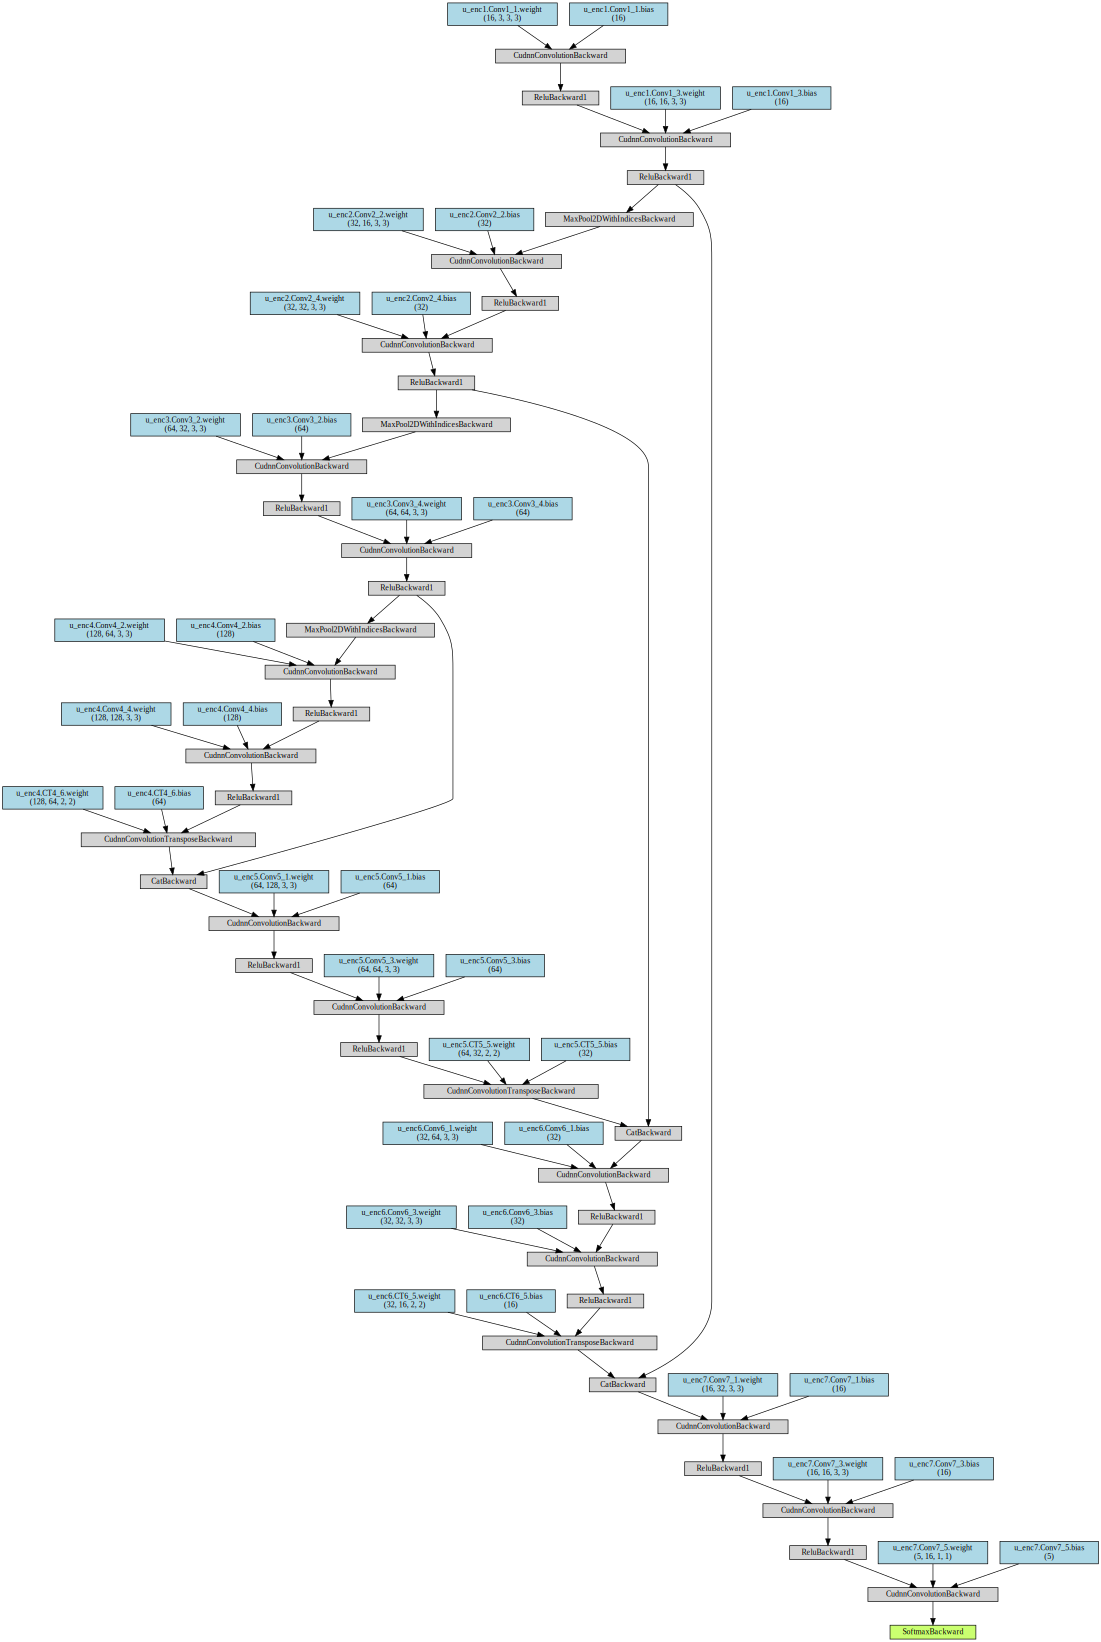

In [46]:
seg = None
for i, images in enumerate(train_loader):
    images_cuda = Variable(images).cuda()
    seg, reconstructed = model(images_cuda)
    break

make_dot(seg, params = dict(model.named_parameters()))


In [ ]:
## Trying with just loss2 because update isn't happening right now

for epoch in range(num_epochs):
    
    
    for i, images in enumerate(train_loader):    # Ignore image labels
        images_cuda = Variable(images).cuda()
        seg, reconstructed = model(images_cuda)
        
        optimizer.zero_grad()
        loss = distance(reconstructed, images_cuda)
        loss.backward()
        optimizer.step()
        
    print("Epoch:", epoch, "Loss = %.3f" % loss.data)

/nethome/jbang36/anaconda3/envs/eva_37/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 0 Loss = 0.050
Epoch: 1 Loss = 0.047
Epoch: 2 Loss = 0.046
Epoch: 3 Loss = 0.052
Epoch: 4 Loss = 0.045
Epoch: 5 Loss = 0.050
Epoch: 6 Loss = 0.050
Epoch: 7 Loss = 0.045
Epoch: 8 Loss = 0.051
Epoch: 9 Loss = 0.054
Epoch: 10 Loss = 0.048
Epoch: 11 Loss = 0.048
Epoch: 12 Loss = 0.050
Epoch: 13 Loss = 0.047
Epoch: 14 Loss = 0.045
Epoch: 15 Loss = 0.048
Epoch: 16 Loss = 0.050
Epoch: 17 Loss = 0.050
Epoch: 18 Loss = 0.050
Epoch: 19 Loss = 0.045
Epoch: 20 Loss = 0.049
Epoch: 21 Loss = 0.048
Epoch: 22 Loss = 0.047
Epoch: 23 Loss = 0.050
Epoch: 24 Loss = 0.047
Epoch: 25 Loss = 0.048
Epoch: 26 Loss = 0.045
Epoch: 27 Loss = 0.048
Epoch: 28 Loss = 0.049
Epoch: 29 Loss = 0.051
Epoch: 30 Loss = 0.049
Epoch: 31 Loss = 0.049
Epoch: 32 Loss = 0.050
Epoch: 33 Loss = 0.053
Epoch: 34 Loss = 0.048
Epoch: 35 Loss = 0.052
Epoch: 36 Loss = 0.048
Epoch: 37 Loss = 0.048
Epoch: 38 Loss = 0.050
Epoch: 39 Loss = 0.048
Epoch: 40 Loss = 0.048


In [54]:
# Loss Function Revision

num_epochs = 100
batch_size = 16
n_samples, H, W, C = X_train_norm.shape

train_data = torch.from_numpy(X_train_norm).float()
train_data = train_data.permute(0,3,1,2)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4, drop_last=True)

dist_diff_matrix = calculate_dist_matrix(batch_size, H,W)


for epoch in range(num_epochs):
    st = time.perf_counter()
    for i, images in enumerate(train_loader):    # Ignore image labels
        images_cuda = Variable(images).cuda()
        seg, recon = model(images_cuda)       
        optimizer.zero_grad()
        loss1 = softcut_loss(seg, images_cuda, dist_diff_matrix)
        loss1.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss2 = distance(reconstructed, images_cuda)
        loss2.backward()
        optimizer.step()
        
    print('epoch [{}/{}], loss1:{:.4f}, loss2:{:.4f}, time elapsed:{:.4f} (sec)'.format(epoch+1, num_epochs, loss1.data, loss2.data, time.perf_counter - st))



RuntimeError: expand(torch.cuda.FloatTensor{[3, 48, 80, 1]}, size=[-1, -1, 3840]): the number of sizes provided (3) must be greater or equal to the number of dimensions in the tensor (4)

In [17]:
import time

num_epochs = 100
batch_size = 16
n_samples, H, W, C = X_train_norm.shape

#start_time = time.perf_counter()


dist_diff_matrix = calculate_dist_matrix(H,W)
#print("time for dist_matrix calculation", time.perf_counter() - start_time, "sec")

for epoch in range(num_epochs):
    st = time.perf_counter()
    for batch in range(n_samples // batch_size):
        #start_time = time.perf_counter()
        img = X_train_norm[batch_size*batch:batch_size*(batch+1),:,:,:]
        img = torch.from_numpy(img).float().cuda()
        img = img.permute(0,3,1,2)
        
        #print("time for batch prep", time.perf_counter() - start_time, "sec")
        #start_time = time.perf_counter()
        #img = Variable(img).cuda()
        # ===================forward=====================
        segmented_img, reconstructed_img = model(img)
        #print("forward run ", time.perf_counter() - start_time, "sec")
        #start_time = time.perf_counter()
        loss1 = softcut_loss(segmented_img, img, dist_diff_matrix)
        #print("softcut_loss forward time", time.perf_counter() - start_time, "sec")
        #start_time = time.perf_counter()
        loss2 = distance(reconstructed_img, img)
        #print("dist_loss forward time", time.perf_counter() - start_time, "sec")
        #start_time = time.perf_counter()
        # ===================backward====================
        #optimizer.zero_grad() #makes all stored gradients zero
        #loss1.backward(retain_graph = True) # calculates the gradients but does not apply them yet
        #print("softcut backward time", time.perf_counter() - start_time, "sec")
        #start_time = time.perf_counter()
        #optimizer.step() # applies the gradients
        #print("softcut gradient update time", time.perf_counter() - start_time, "sec")
        #start_time = time.perf_counter()
        optimizer.zero_grad()
        loss2.backward()
        #print("dist_loss backward time", time.perf_counter() - start_time, "sec")
        #start_time = time.perf_counter()
        optimizer.step()
        #print("dist_loss update time", time.perf_counter() - start_time, "sec")
        #print("====================================")
            # ===================log========================
    #print('epoch [{}/{}], loss1:{:.4f}'.format(epoch+1, num_epochs, loss1.data))
    print('epoch [{}/{}], loss2:{:.4f}'.format(epoch+1, num_epochs, loss2.data))
    print("epoch time", time.perf_counter() - st)

epoch [1/100], loss2:0.0834
epoch time 11.696322357282043
epoch [2/100], loss2:0.0834
epoch time 11.630809308961034
epoch [3/100], loss2:0.0834
epoch time 11.649657383561134
epoch [4/100], loss2:0.0834
epoch time 11.553738294169307
epoch [5/100], loss2:0.0834
epoch time 11.482074737548828


KeyboardInterrupt: 

In [16]:
num_epochs = 1
n_samples, _, _, _ = X_train_norm.shape

for epoch in range(num_epochs):
    for i in range(n_samples):
        img = X_train_norm[i,:,:,:]
        img = torch.from_numpy(img).float().cuda()
        #img = Variable(img).cuda()
        # ===================forward=====================
        segmented_img, reconstructed_img = model(img)
        loss1 = softcut_loss(segmented_img, data)
        loss2 = distance(reconstructed_img, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss1.backward()
        optimizer.step()
        loss2.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.data))

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 16 3 3, but got 3-dimensional input of size [48, 80, 3] instead

In [ ]:
### Tensorflow / Keras version but custom loss function doesn't work as expected.. very hard to debug


In [9]:
def batch_wrapper(x):
    return BatchNormalization(axis=3, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', 
                                moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                beta_constraint=None, gamma_constraint=None)(x)
    
    

In [10]:
def U_net(input_layer_needed, x = None, width = 0, height = 0, output_channels = 3):
    
    if input_layer_needed:
        x = Input(shape=(width, height, 3))
    if input_layer_needed == False and x == None:
        print("Input layer is needed or X is needed... returning")
        return None
    
    # Encoder
    x1 = Conv2D(16,(3,3),
               activation='relu',
               padding='same')(x)
    x1 = batch_wrapper(x1)
    x1 = Conv2D(16,(3,3),
               activation='relu',
               padding='same')(x1)
    x1 = batch_wrapper(x1)
    x2 = MaxPooling2D((2,2),
                     padding='same')(x1) 

    x2 = Conv2D(32,(3,3),
               activation='relu',
               padding='same')(x2)
    x2 = batch_wrapper(x2)
    x2 = Conv2D(32,(3,3),
               activation='relu',
               padding='same')(x2)
    x2 = batch_wrapper(x2)
    x3 = MaxPooling2D((2,2),
                     padding='same')(x2) 

    x3 = Conv2D(64,(3,3),
               activation='relu',
               padding='same')(x3)
    x3 = batch_wrapper(x3)
    x3 = Conv2D(64,(3,3),
               activation='relu',
               padding='same')(x3)
    x3 = batch_wrapper(x3)
    x4 = MaxPooling2D((2,2),
                     padding='same')(x3) 

    x4 = Conv2D(128,(3,3),
               activation='relu',
               padding='same')(x4)
    x4 = batch_wrapper(x4)
    x4 = Conv2D(128,(3,3),
               activation='relu',
               padding='same')(x4)
    x4 = batch_wrapper(x4)

    x5 = UpSampling2D((2, 2))(x4)
    x5 = Concatenate(axis=-1)([x3, x5]) #channels should be 296
    x5 = Conv2D(128,(3,3),
               activation='relu',
               padding='same')(x5)
    x5 = batch_wrapper(x5)
    x5 = Conv2D(128,(3,3),
               activation='relu',
               padding='same')(x5)
    x5 = batch_wrapper(x5)

    x6 = UpSampling2D((2, 2))(x5)
    x6 = Concatenate(axis=-1)([x2, x6]) #channels should be 296
    x6 = Conv2D(64,(3,3),
               activation='relu',
               padding='same')(x6)
    x6 = batch_wrapper(x6)
    x6 = Conv2D(64,(3,3),
               activation='relu',
               padding='same')(x6)
    x6 = batch_wrapper(x6)

    x7 = UpSampling2D((2, 2))(x6)
    x7 = Concatenate(axis=-1)([x1, x7]) #channels should be 296
    x7 = Conv2D(32,(3,3),
               activation='relu',
               padding='same')(x7)
    x7 = batch_wrapper(x7)
    x7 = Conv2D(32,(3,3),
               activation='relu',
               padding='same')(x7)
    x7 = batch_wrapper(x7)

    xk = Conv2D(output_channels, (1,1), 
               activation='softmax',
               padding='same')(x7)
    
    #will return first, last layer made
    return [x, xk]

    
    

In [12]:
a = tf.Variable([1,2,3,4,5])
b = tf.constant([1,2,3,4,5])
print(a)
print(a[0],a[1])
tf.math.reduce_sum(a)
c = tf.math.reduce_sum(b)

tf.Session().run(c)


<tf.Variable 'Variable_1:0' shape=(5,) dtype=int32_ref>
Tensor("strided_slice_2:0", shape=(), dtype=int32) Tensor("strided_slice_3:0", shape=(), dtype=int32)


15

In [56]:
# define our custom loss function - Soft Normalized Cut Loss
### Here is an example of a defined loss function 
"""
from . import backend as K
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

model.compile(loss=losses.mean_squared_error, optimizer='sgd')
"""

import tensorflow as tf

import math

def soft_normalized_cut_loss(y_true, y_pred):
    def weight_function(p1,d1,p2,d2):
        sigma_i = 10
        sigma_x = 4
        sigma_i_tf = tf.constant(sigma_i**2, dtype=tf.float32)
        sigma_x_tf = tf.constant(sigma_x**2, dtype=tf.float32)
        r = tf.constant(5, dtype = tf.float32)
        tf.Print(r.shape)
        #normed = math.sqrt((d1[0] - d2[0])**2 + (d1[1] - d2[1])**2)
        normed = tf.keras.backend.l2_normalize(p1 - p2)
        pixel_diff = tf.math.exp(-1.0 * normed / sigma_x_tf) # Make sure this is sigma_x
        tmp = tf.dtypes.cast((d1 - d2), dtype = tf.float32)
        tmp1 = tf.math.pow(tmp,2)
        threshold = tf.math.sqrt(tmp1)
        #threshold = tf.keras.backend.l2_normalize(d1 - d2)
        dist_diff = tf.math.exp(-1.0 * threshold**2 / sigma_i_tf) # Make sure this is sigma_i
        return dist_diff * pixel_diff
    
    n_samples, row,col,K = y_pred.shape
    
    for k in range(0,K):
        val = 0
        num = 0
        denom = 0
        sheet = y_pred[:][:][k]
        for i in range(row):
            for j in range(col):
                num_pixel = sheet[i][j]
                denom_pixel = sheet[i][j]
                v_term = 0
                t_term = 0
                for ii in range(row):
                    for jj in range(col):
                        weight = weight_function(y_true[i][j], tf.constant([i, j]), y_true[ii][jj], tf.constant([ii, jj]))
                        v_term += y_pred[ii][jj][k] * weight          
                        t_term += weight
                    num_pixel *= v_term
                    denom_pixel *= t_term
                num += num_pixel
                denom += denom_pixel
                val += num / denom
      
    return k - val
    
    
    
    
    


In [225]:
# we will create W-Net
# our input will be 48, 80
# we will decrease the amount of channels we will need to perform tasks

# Combined network with both FC and CNN layers

n_samples, width, height, channels = X_train_norm.shape
#how many layers we want to segment as
k = 10


input_layer, xk = U_net(True, width=width, height=height, output_channels = k)
_, output = U_net(False, xk)

u_enc = Model(input_layer, xk)
#u_dec = Model(xk, output)
w_net = Model(input_layer, output)

# We must define our custom loss function...
u_enc.compile(optimizer='sgd', loss=soft_normalized_cut_loss)
w_net.compile(optimizer='sgd', loss='mse')

u_enc.summary()
w_net.summary()

NameError: name 'U_net' is not defined